In [3]:
# import request library 
import requests
import json
import io
from pathlib import Path
import pandas as pd
from pvlib.iotools import read_epw, parse_epw
# import plotting library
import matplotlib
import matplotlib.pyplot as plt 
import datetime


In [4]:

URL = 'https://re.jrc.ec.europa.eu/api/'


def get_pvgis_tmy(lat, lon, outputformat='json', usehorizon=True,
                  userhorizon=None, startyear=None, endyear=None, url=URL,
                  timeout=30):
    """
    Get TMY data from PVGIS. For more information see the PVGIS [1]_ TMY tool
    documentation [2]_.
    Parameters
    ----------
    lat : float
        Latitude in degrees north
    lon : float
        Longitude in dgrees east
    outputformat : str, default 'json'
        Must be in ``['csv', 'basic', 'epw', 'json']``. See PVGIS TMY tool
        documentation [2]_ for more info.
    usehorizon : bool, default True
        include effects of horizon
    userhorizon : list of float, default None
        optional user specified elevation of horizon in degrees, at equally
        spaced azimuth clockwise from north, only valid if `usehorizon` is
        true, if `usehorizon` is true but `userhorizon` is `None` then PVGIS
        will calculate the horizon [3]_
    startyear : int, default None
        first year to calculate TMY
    endyear : int, default None
        last year to calculate TMY, must be at least 10 years from first year
    url : str, default :const:`pvlib.iotools.pvgis.URL`
        base url of PVGIS API, append ``tmy`` to get TMY endpoint
    timeout : int, default 30
        time in seconds to wait for server response before timeout
    Returns
    -------
    data : pandas.DataFrame
        the weather data
    months_selected : list
        TMY year for each month, ``None`` for basic and EPW
    inputs : dict
        the inputs, ``None`` for basic and EPW
    meta : list or dict
        meta data, ``None`` for basic
    Raises
    ------
    requests.HTTPError
        if the request response status is ``HTTP/1.1 400 BAD REQUEST``, then
        the error message in the response will be raised as an exception,
        otherwise raise whatever ``HTTP/1.1`` error occurred
    See also
    --------
    read_pvgis_tmy
    References
    ----------
    .. [1] `PVGIS <https://ec.europa.eu/jrc/en/pvgis>`_
    .. [2] `PVGIS TMY tool <https://ec.europa.eu/jrc/en/PVGIS/tools/tmy>`_
    .. [3] `PVGIS horizon profile tool
       <https://ec.europa.eu/jrc/en/PVGIS/tools/horizon>`_
    """
    # use requests to format the query string by passing params dictionary
    params = {'lat': lat, 'lon': lon, 'outputformat': outputformat}
    # pvgis only likes 0 for False, and 1 for True, not strings, also the
    # default for usehorizon is already 1 (ie: True), so only set if False
    if not usehorizon:
        params['usehorizon'] = 0
    if userhorizon is not None:
        params['userhorizon'] = ','.join(str(x) for x in userhorizon)
    if startyear is not None:
        params['startyear'] = startyear
    if endyear is not None:
        params['endyear'] = endyear
    res = requests.get(url + 'tmy', params=params, timeout=timeout)
    # PVGIS returns really well formatted error messages in JSON for HTTP/1.1
    # 400 BAD REQUEST so try to return that if possible, otherwise raise the
    # HTTP/1.1 error caught by requests
    if not res.ok:
        try:
            err_msg = res.json()
        except Exception:
            res.raise_for_status()
        else:
            raise requests.HTTPError(err_msg['message'])
    # initialize data to None in case API fails to respond to bad outputformat
    data = None, None, None, None
    if outputformat == 'json':
        src = res.json()
        return _parse_pvgis_tmy_json(src)
    elif outputformat == 'csv':
        with io.BytesIO(res.content) as src:
            data = _parse_pvgis_tmy_csv(src)
    elif outputformat == 'basic':
        with io.BytesIO(res.content) as src:
            data = _parse_pvgis_tmy_basic(src)
    elif outputformat == 'epw':
        with io.StringIO(res.content.decode('utf-8')) as src:
            data, meta = parse_epw(src)
            data = (data, None, None, meta)
    else:
        # this line is never reached because if outputformat is not valid then
        # the response is HTTP/1.1 400 BAD REQUEST which is handled earlier
        pass
    return data


def _parse_pvgis_tmy_json(src):
    inputs = src['inputs']
    meta = src['meta']
    months_selected = src['outputs']['months_selected']
    data = pd.DataFrame(src['outputs']['tmy_hourly'])
    data.index = pd.to_datetime(
        data['time(UTC)'], format='%Y%m%d:%H%M', utc=True)
    data = data.drop('time(UTC)', axis=1)
    return data, months_selected, inputs, meta


def _parse_pvgis_tmy_csv(src):
    # the first 3 rows are latitude, longitude, elevation
    inputs = {}
    # 'Latitude (decimal degrees): 45.000\r\n'
    inputs['latitude'] = float(src.readline().split(b':')[1])
    # 'Longitude (decimal degrees): 8.000\r\n'
    inputs['longitude'] = float(src.readline().split(b':')[1])
    # Elevation (m): 1389.0\r\n
    inputs['elevation'] = float(src.readline().split(b':')[1])
    # then there's a 13 row comma separated table with two columns: month, year
    # which contains the year used for that month in the
    src.readline()  # get "month,year\r\n"
    months_selected = []
    for month in range(12):
        months_selected.append(
            {'month': month+1, 'year': int(src.readline().split(b',')[1])})
    # then there's the TMY (typical meteorological year) data
    # first there's a header row:
    #    time(UTC),T2m,RH,G(h),Gb(n),Gd(h),IR(h),WS10m,WD10m,SP
    headers = [h.decode('utf-8').strip() for h in src.readline().split(b',')]
    data = pd.DataFrame(
        [src.readline().split(b',') for _ in range(8760)], columns=headers)
    dtidx = data['time(UTC)'].apply(lambda dt: dt.decode('utf-8'))
    dtidx = pd.to_datetime(dtidx, format='%Y%m%d:%H%M', utc=True)
    data = data.drop('time(UTC)', axis=1)
    data = pd.DataFrame(data, dtype=float)
    data.index = dtidx
    # finally there's some meta data
    meta = [line.decode('utf-8').strip() for line in src.readlines()]
    return data, months_selected, inputs, meta


def _parse_pvgis_tmy_basic(src):
    data = pd.read_csv(src)
    data.index = pd.to_datetime(
        data['time(UTC)'], format='%Y%m%d:%H%M', utc=True)
    data = data.drop('time(UTC)', axis=1)
    return data, None, None, None


def read_pvgis_tmy(filename, pvgis_format=None):
    """
    Read a file downloaded from PVGIS.
    Parameters
    ----------
    filename : str, pathlib.Path, or file-like buffer
        Name, path, or buffer of file downloaded from PVGIS.
    pvgis_format : str, default None
        Format of PVGIS file or buffer. Equivalent to the ``outputformat``
        parameter in the PVGIS TMY API. If `filename` is a file and
        `pvgis_format` is ``None`` then the file extension will be used to
        determine the PVGIS format to parse. For PVGIS files from the API with
        ``outputformat='basic'``, please set `pvgis_format` to ``'basic'``. If
        `filename` is a buffer, then `pvgis_format` is required and must be in
        ``['csv', 'epw', 'json', 'basic']``.
    Returns
    -------
    data : pandas.DataFrame
        the weather data
    months_selected : list
        TMY year for each month, ``None`` for basic and EPW
    inputs : dict
        the inputs, ``None`` for basic and EPW
    meta : list or dict
        meta data, ``None`` for basic
    Raises
    ------
    ValueError
        if `pvgis_format` is ``None`` and the file extension is neither
        ``.csv``, ``.json``, nor ``.epw``, or if `pvgis_format` is provided as
        input but isn't in ``['csv', 'epw', 'json', 'basic']``
    TypeError
        if `pvgis_format` is ``None`` and `filename` is a buffer
    See also
    --------
    get_pvgis_tmy
    """
    # get the PVGIS outputformat
    if pvgis_format is None:
        # get the file extension from suffix, but remove the dot and make sure
        # it's lower case to compare with epw, csv, or json
        # NOTE: raises TypeError if filename is a buffer
        outputformat = Path(filename).suffix[1:].lower()
    else:
        outputformat = pvgis_format

    # parse the pvgis file based on the output format, either 'epw', 'json',
    # 'csv', or 'basic'

    # EPW: use the EPW parser from the pvlib.iotools epw.py module
    if outputformat == 'epw':
        try:
            data, meta = parse_epw(filename)
        except AttributeError:  # str/path has no .read() attribute
            data, meta = read_epw(filename)
        return data, None, None, meta

    # NOTE: json, csv, and basic output formats have parsers defined as private
    # functions in this module

    # JSON: use Python built-in json module to convert file contents to a
    # Python dictionary, and pass the dictionary to the _parse_pvgis_tmy_json()
    # function from this module
    if outputformat == 'json':
        try:
            src = json.load(filename)
        except AttributeError:  # str/path has no .read() attribute
            with open(str(filename), 'r') as fbuf:
                src = json.load(fbuf)
        return _parse_pvgis_tmy_json(src)

    # CSV or basic: use the correct parser from this module
    # eg: _parse_pvgis_tmy_csv() or _parse_pvgist_tmy_basic()
    if outputformat in ['csv', 'basic']:
        # get the correct parser function for this output format from globals()
        pvgis_parser = globals()['_parse_pvgis_tmy_{:s}'.format(outputformat)]
        # NOTE: pvgis_parse() is a pvgis parser function from this module,
        # either _parse_pvgis_tmy_csv() or _parse_pvgist_tmy_basic()
        try:
            pvgis_data = pvgis_parser(filename)
        except AttributeError:  # str/path has no .read() attribute
            with open(str(filename), 'rb') as fbuf:
                pvgis_data = pvgis_parser(fbuf)
        return pvgis_data

    # raise exception if pvgis format isn't in ['csv', 'basic', 'epw', 'json']
    err_msg = (
        "pvgis format '{:s}' was unknown, must be either 'epw', 'json', 'csv'"
        ", or 'basic'").format(outputformat)
    raise ValueError(err_msg)


# Wind turbine

In [5]:
URL = 'https://re.jrc.ec.europa.eu/api/'


#Geolocation of wind turbines in Spaina: https://amezet.carto.com/builder/fd430f8c-41cb-11e7-876d-0ecd1babdde5/embed
# Wind turbine El Prat de Llobregat


lat = 41.305822
long = 2.131127
outputformat='json'
usehorizon=True
userhorizon=None
startyear = 2006
endyear=2016
url=URL
timeout=30

print('Wind and irradiance values where a wind turbine is located:')
get_pvgis_tmy(lat, long, outputformat, usehorizon,userhorizon, startyear, endyear, url,timeout)



Wind and irradiance values where a wind turbine is located:


(                            T2m     RH  G(h)  Gb(n)  Gd(h)   IR(h)  WS10m  \
 time(UTC)                                                                   
 2008-01-01 00:00:00+00:00  3.02  90.75   0.0    0.0    0.0  291.71   2.98   
 2008-01-01 01:00:00+00:00  2.14  90.16   0.0    0.0    0.0  288.41   3.03   
 2008-01-01 02:00:00+00:00  1.26  89.57   0.0    0.0    0.0  285.12   3.07   
 2008-01-01 03:00:00+00:00  0.38  88.99   0.0    0.0    0.0  281.82   3.12   
 2008-01-01 04:00:00+00:00 -0.50  88.40   0.0    0.0    0.0  278.52   3.16   
 ...                         ...    ...   ...    ...    ...     ...    ...   
 2008-12-31 19:00:00+00:00  7.42  93.69   0.0    0.0    0.0  308.19   2.75   
 2008-12-31 20:00:00+00:00  6.54  93.10   0.0    0.0    0.0  304.89   2.80   
 2008-12-31 21:00:00+00:00  5.66  92.51   0.0    0.0    0.0  301.60   2.85   
 2008-12-31 22:00:00+00:00  4.78  91.93   0.0    0.0    0.0  298.30   2.89   
 2008-12-31 23:00:00+00:00  3.90  91.34   0.0    0.0    0.0  295

In [6]:
data = get_pvgis_tmy(lat, long, outputformat, usehorizon,userhorizon, startyear, endyear, url,timeout)

table = data[0]

WindData=table['WS10m']
DateData=table.index  # Data every hour 
print(WindData)

windspeed = []
for i in range(len(WindData)):
    windspeed.append(WindData[i]) # A list with Wind Speed data


time(UTC)
2008-01-01 00:00:00+00:00    2.98
2008-01-01 01:00:00+00:00    3.03
2008-01-01 02:00:00+00:00    3.07
2008-01-01 03:00:00+00:00    3.12
2008-01-01 04:00:00+00:00    3.16
                             ... 
2008-12-31 19:00:00+00:00    2.75
2008-12-31 20:00:00+00:00    2.80
2008-12-31 21:00:00+00:00    2.85
2008-12-31 22:00:00+00:00    2.89
2008-12-31 23:00:00+00:00    2.94
Name: WS10m, Length: 8760, dtype: float64


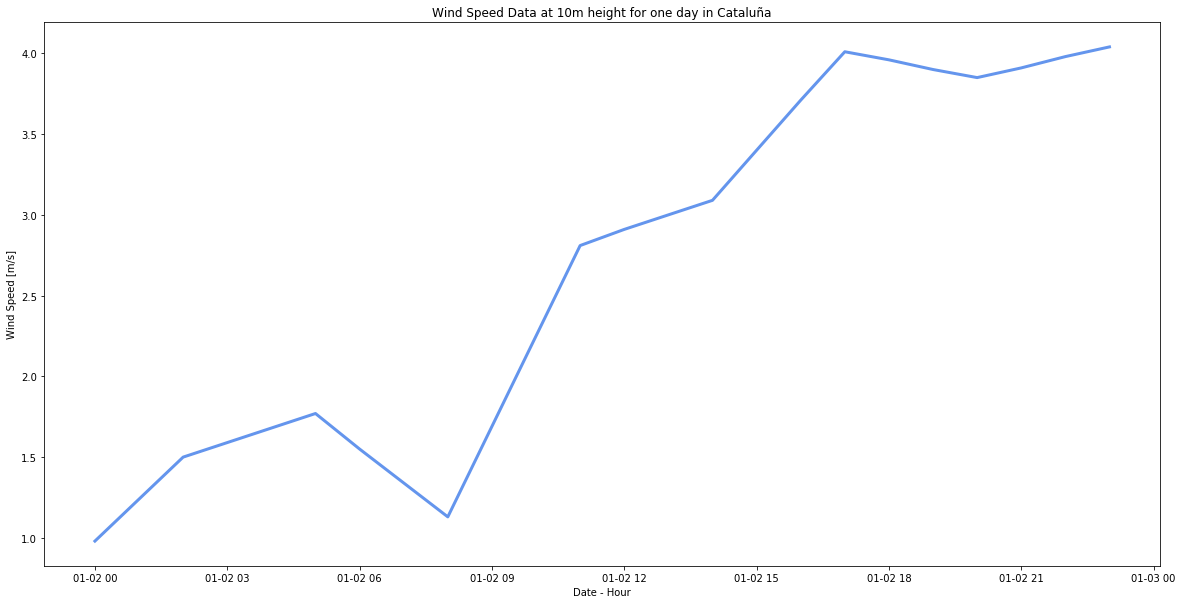

In [7]:
# Wind data for one day 
plt.figure(figsize=(20,10))
plt.plot(WindData['2008-01-02'],'r',linewidth=3, color='cornflowerblue')
plt.title(f"Wind Speed Data at 10m height for one day in Cataluña")
plt.xlabel('Date - Hour')
plt.ylabel('Wind Speed [m/s]')
plt.show()

# PV panels 

In [8]:
# Location of SEAT factory at Martorell (Cataluña) where a large solar plant is installed

lat =41.4978538028809
long =  1.903210340349628
outputformat='json'
usehorizon=True
userhorizon=None
startyear = 2006
endyear=2016
url=URL
timeout=30

get_pvgis_tmy(lat, long, outputformat, usehorizon,userhorizon, startyear, endyear, url,timeout)



(                            T2m     RH  G(h)  Gb(n)  Gd(h)   IR(h)  WS10m  \
 time(UTC)                                                                   
 2009-01-01 00:00:00+00:00  2.72  85.01   0.0    0.0    0.0  306.86   2.14   
 2009-01-01 01:00:00+00:00  2.80  87.55   0.0    0.0    0.0  312.47   2.03   
 2009-01-01 02:00:00+00:00  2.89  90.08   0.0    0.0    0.0  318.08   1.92   
 2009-01-01 03:00:00+00:00  2.97  92.61   0.0    0.0    0.0  323.69   1.82   
 2009-01-01 04:00:00+00:00  3.05  95.14   0.0    0.0    0.0  329.31   1.71   
 ...                         ...    ...   ...    ...    ...     ...    ...   
 2007-12-31 19:00:00+00:00  2.30  72.36   0.0    0.0    0.0  278.79   2.69   
 2007-12-31 20:00:00+00:00  2.38  74.89   0.0    0.0    0.0  284.41   2.58   
 2007-12-31 21:00:00+00:00  2.47  77.42   0.0    0.0    0.0  290.02   2.47   
 2007-12-31 22:00:00+00:00  2.55  79.95   0.0    0.0    0.0  295.63   2.36   
 2007-12-31 23:00:00+00:00  2.63  82.48   0.0    0.0    0.0  301

In [10]:
data2 = get_pvgis_tmy(lat, long, outputformat, usehorizon,userhorizon, startyear, endyear, url,timeout)

table = data2[0]

IrradianceData=table['G(h)']
DateData=table.index  # Data every hour 
print(IrradianceData)


time(UTC)
2009-01-01 00:00:00+00:00    0.0
2009-01-01 01:00:00+00:00    0.0
2009-01-01 02:00:00+00:00    0.0
2009-01-01 03:00:00+00:00    0.0
2009-01-01 04:00:00+00:00    0.0
                            ... 
2007-12-31 19:00:00+00:00    0.0
2007-12-31 20:00:00+00:00    0.0
2007-12-31 21:00:00+00:00    0.0
2007-12-31 22:00:00+00:00    0.0
2007-12-31 23:00:00+00:00    0.0
Name: G(h), Length: 8760, dtype: float64


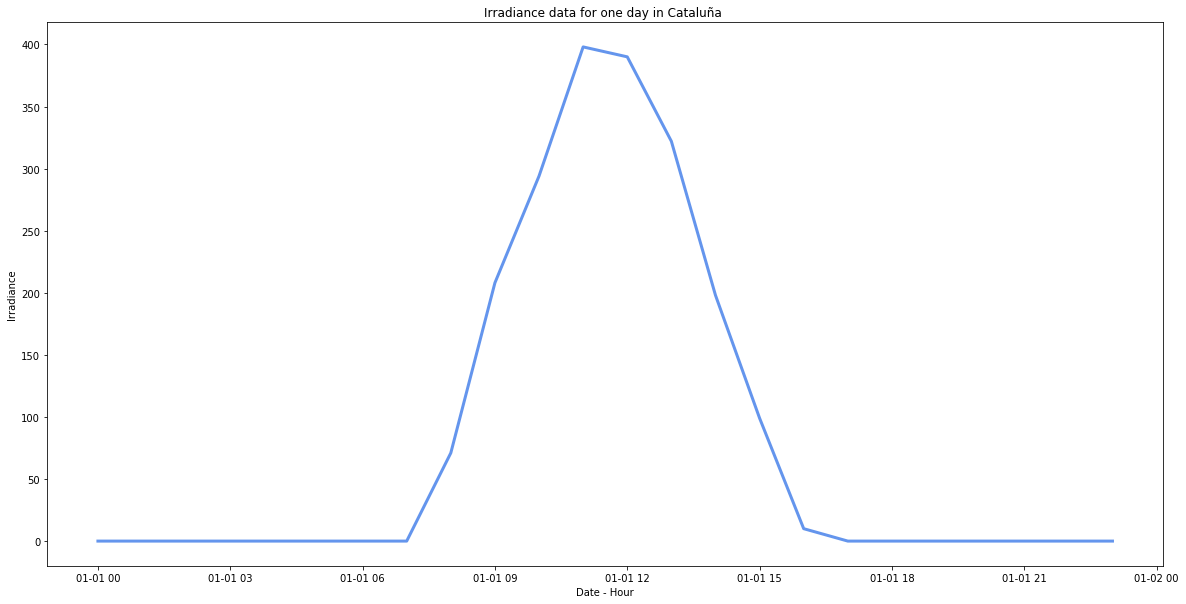

In [11]:
# Irradiance data for one day
# Wind data for one day 
plt.figure(figsize=(20,10))
plt.plot(IrradianceData['2009-01-01'],'r',linewidth=3, color='cornflowerblue')
plt.title(f"Irradiance data for one day in Cataluña ")
plt.xlabel('Date - Hour')
plt.ylabel('Irradiance')
plt.show()

# Data during charging time

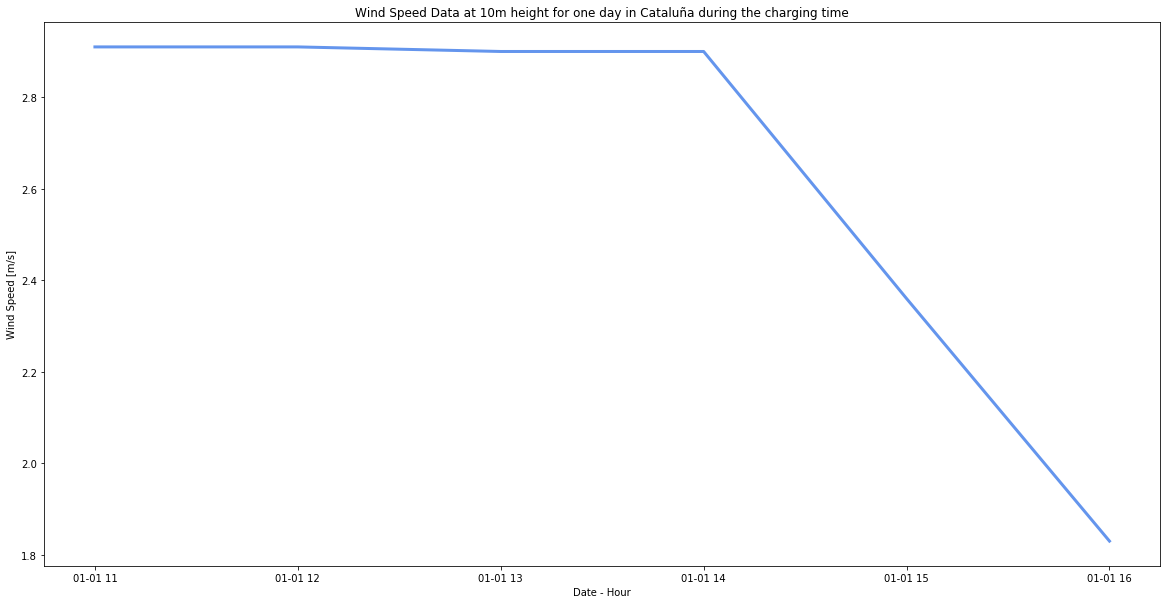

In [58]:
#Plot the wind speed and irradiance for those 5h of any day

current_date_and_time = datetime.datetime.now()
current_hour =  datetime.datetime.now().hour

hours = 5
hours_added = datetime.timedelta(hours = hours)
after_charge = current_date_and_time + hours_added
charge_time = after_charge.hour



day_start = '2008-01-01'
hour_start= str(current_hour) + ':00:00+00:00'
date_start = day_start + " " + hour_start

day_end='2008-01-01'
hour_end= str(charge_time) + ':00:00+00:00'
date_end = day_end + " " + hour_end

# Wind data for one day 
plt.figure(figsize=(20,10))
plt.plot(WindData[date_start:date_end],'r',linewidth=3, color='cornflowerblue')
plt.title(f"Wind Speed Data at 10m height for one day in Cataluña during the charging time")
plt.xlabel('Date - Hour')
plt.ylabel('Wind Speed [m/s]')
plt.show()


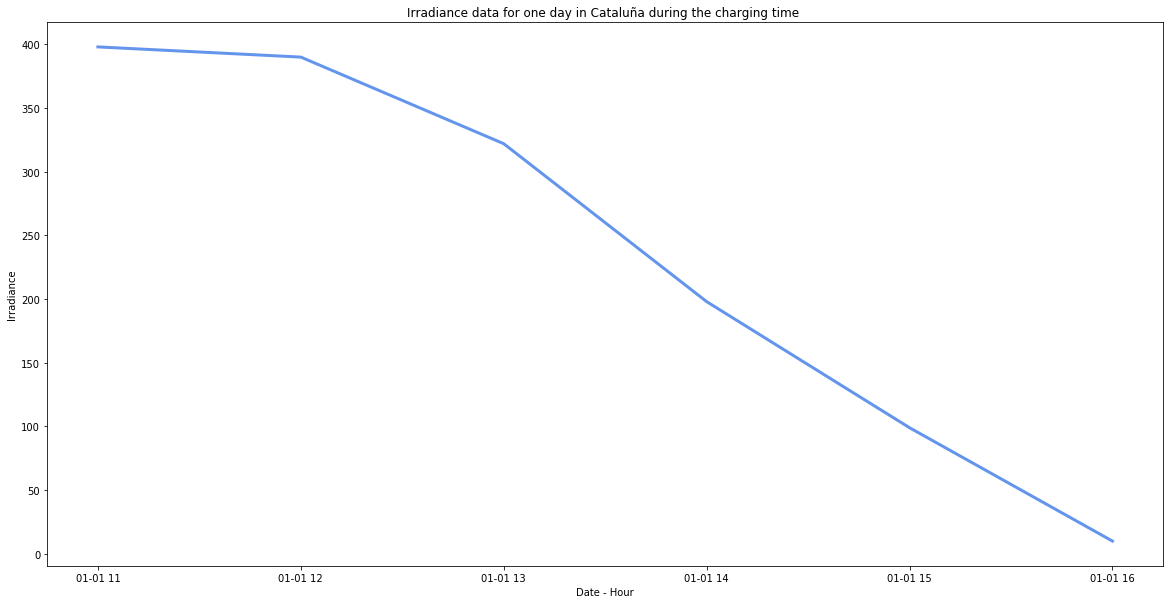

In [59]:
day_start = '2009-01-01'
hour_start= str(current_hour) + ':00:00+00:00'
date_start = day_start + " " + hour_start

day_end='2009-01-01'
hour_end= str(charge_time) + ':00:00+00:00'
date_end = day_end + " " + hour_end


#Irradiance during the charging time
plt.figure(figsize=(20,10))
plt.plot(IrradianceData[date_start:date_end],'r',linewidth=3, color='cornflowerblue')
plt.title(f"Irradiance data for one day in Cataluña during the charging time ")
plt.xlabel('Date - Hour')
plt.ylabel('Irradiance')
plt.show()